In [14]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import easyocr
import re

In [2]:
def preprocessing(image, max_value=255, adaptive_method=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                  threshold_type=cv2.THRESH_BINARY, block_size=11, C=2, kernel_size=(1, 1), blur_ksize=3):
    if image is None:
        raise ValueError("Image đầu vào không hợp lệ hoặc không tồn tại.")

    # if len(image.shape) == 3:
    #     processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2GRAY)
    # else:
    #     processed_image = image

    # Áp dụng Adaptive Thresholding
    thresh, im_bw = cv2.threshold(image, 202, 255, cv2.THRESH_BINARY)
    kernel = np.ones(kernel_size, np.uint8)

    denoise_image = cv2.dilate(im_bw, kernel, iterations=1)
    denoise_image = cv2.erode(denoise_image, kernel, iterations=1)
    denoise_image = cv2.morphologyEx(denoise_image, cv2.MORPH_CLOSE, kernel)

    denoise_image = cv2.medianBlur(denoise_image, blur_ksize)

    return denoise_image
def thick_font(image):
    image = cv2.bitwise_not(image)
    kernel = np.ones((2,2),np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    image = cv2.bitwise_not(image)
    return (image)

In [3]:
def getSkewAngle(cvImage) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    newImage = cvImage.copy()
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=2)

    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    for c in contours:
        rect = cv2.boundingRect(c)
        x,y,w,h = rect
        cv2.rectangle(newImage,(x,y),(x+w,y+h),(0,255,0),2)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    print (len(contours))
    minAreaRect = cv2.minAreaRect(largestContour)
    # cv2.imwrite("output/boxes.jpg", newImage)
    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle
# Rotate the image around its center
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage
def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)

In [6]:
image_test_path = os.path.join('.', 'page_01.jpg')

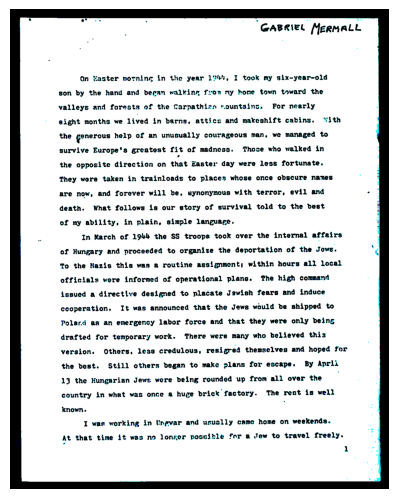

In [7]:
image = cv2.imread(image_test_path)
if image is None:
    print("Failed to load image. Please check the file path.")
else:
    image = preprocessing(image)
    image = thick_font(image)
    # image = deskew(image)
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(image, cmap='gray')

    plt.show()

In [8]:
def process_text(text):
    text = text.lower()
    processed_text = re.sub(r'[^a-z0-9\s]', '', text)  # Giữ chữ cái, số, và khoảng trắng
    processed_text = re.sub(r'\s+', ' ', processed_text)  # Loại bỏ khoảng trắng/tab dư thừa
    return processed_text.strip()

In [9]:
reader = easyocr.Reader(['en'])

In [10]:
def easy_ocr(image_path):
    image = cv2.imread(image_path)
    image = preprocessing(image)
    image = thick_font(image)
    results = reader.readtext(image)
    d = pd.DataFrame(results, columns=['bbox','text','conf'])
    # Lấy văn bản từ cột 'utf8_string'
    text = d['text'].tolist()
    
    # Ghép các văn bản, chuyển chữ thường
    raw_text = ' '.join(text).lower()
    
    return process_text(raw_text)


In [15]:
easy_ocr(image_test_path)

'gabriel mermall on xster nozning in lhc year 1334 i took my sixycarold son by the hand and becan walkinc t0 ny porc town toward the valleye ard forests of thc garzathi runtans for ncarly eight months we lived in barns attscc ard makcghfft cabins ith the holp of an unugually courageous man wc managed to survive europe 8 grcatost fit of madncg0 thoce kho walked in the oppositc direction on that easter day were 1og8 fortunate wore taken in trainloads to places whose once obscure nae8 are now and forcver will be bynonyroub with terror evfl and death what ollowg 18 our btory of survival told to the best 0f my abiljty in plain oimple laneueec in march of 1944 the ss troopr took over the internal affelrs of hungary and procceded to organfze the deportetlon of the jowe to the mazis thle wa9 routine a88 gnmont within hourg a11 local officlals wcre informcd of operational planb the high commerd is8u0d directive desf to dlacate jawich fears and induce cooperatior it was announced that tho jewg w